<a href="https://colab.research.google.com/github/prashanth018/Text-Summarization/blob/shreya/Copy_of_NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import io
import re
import spacy
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import os

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [3]:
from google.colab import files
uploaded = files.upload()

Saving News_Category_Dataset-15129-17000.csv to News_Category_Dataset-15129-17000.csv


In [4]:
dataset = pd.read_csv(io.BytesIO(uploaded[r'News_Category_Dataset-15129-17000.csv']))
dataset

,Unnamed: 0,news_text,category,headline,short_desc,url
0,1,"A young boy in Tucuman, Argentina, suffered an...",WEIRD NEWS,Boy Swallows Piece Of Pet Toy And Can't Stop S...,Honk!,https://www.huffingtonpost.com/entry/argentina...
1,2,Stephen Paddock brought an arsenal of weapons ...,CRIME,Las Vegas Gunman Had 'Cache Of Weapons',"The gunfire ""just kept coming,"" a witness said...",https://www.huffingtonpost.com/entry/las-vegas...
2,3,Journalists and commentators on Monday immedia...,POLITICS,Journalists And Pundits Praise Trump's Respons...,The pattern of praising Trump for reading from...,https://www.huffingtonpost.com/entry/trump-las...
3,4,Jennifer Garner is not afraid to show her exha...,PARENTS,Parents Are Totally Relating To Jennifer Garne...,The actress has been keeping up this annual tr...,https://www.huffingtonpost.com/entry/parents-a...
4,5,After the deadliest mass shooting in modern U....,POLITICS,Politicians Offer Thoughts And Prayers After D...,But will they do anything?,https://www.huffingtonpost.com/entry/las-vegas...
...,...,...,...,...,...,...
785,786,You don't need croutons when your salad comes ...,TASTE,10 Food Truths You'll Understand If You're Fro...,You want fries with that? Then go to Pittsburgh.,https://www.huffingtonpost.com/entry/pittsburg...
786,787,THE OBAMACARE REPEAL WILL COME DOWN TO THESE T...,POLITICS,Thursday's Morning Email: The Obamacare Repeal...,"What will Sens. Susan Collins, Lisa Murkowski ...",https://www.huffingtonpost.com/entry/thursdays...
787,788,By Max Falkowitz\n\nStorey Publishing Bean-to-...,TASTE,The Future of $10 Chocolate,Chocolate journalist Megan Giller explains how...,https://www.huffingtonpost.com/entry/the-futur...
788,789,President Donald Trump has had an awful first ...,POLITICS,The GOP Plays Politics With Your Health,No wonder nearly 70 percent of all Americans d...,https://www.huffingtonpost.com/entry/the-gop-p...


In [5]:
df = pd.DataFrame()
df['news_text'] = dataset['news_text']
df['headline'] = dataset['headline']
df

,news_text,headline
0,"A young boy in Tucuman, Argentina, suffered an...",Boy Swallows Piece Of Pet Toy And Can't Stop S...
1,Stephen Paddock brought an arsenal of weapons ...,Las Vegas Gunman Had 'Cache Of Weapons'
2,Journalists and commentators on Monday immedia...,Journalists And Pundits Praise Trump's Respons...
3,Jennifer Garner is not afraid to show her exha...,Parents Are Totally Relating To Jennifer Garne...
4,After the deadliest mass shooting in modern U....,Politicians Offer Thoughts And Prayers After D...
...,...,...
785,You don't need croutons when your salad comes ...,10 Food Truths You'll Understand If You're Fro...
786,THE OBAMACARE REPEAL WILL COME DOWN TO THESE T...,Thursday's Morning Email: The Obamacare Repeal...
787,By Max Falkowitz\n\nStorey Publishing Bean-to-...,The Future of $10 Chocolate
788,President Donald Trump has had an awful first ...,The GOP Plays Politics With Your Health


In [6]:
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [7]:
processed_text = text_strip(df['news_text'])
processed_summary = text_strip(df['headline'])
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=500)]
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=500)]

In [8]:
df['cleaned_news_text'] = pd.Series(text)
df['cleaned_headline'] = pd.Series(summary)

In [9]:
df

,news_text,headline,cleaned_news_text,cleaned_headline
0,"A young boy in Tucuman, Argentina, suffered an...",Boy Swallows Piece Of Pet Toy And Can't Stop S...,a young boy in tucuman argentina suffered an u...,_START_ boy swallows piece of pet toy and can ...
1,Stephen Paddock brought an arsenal of weapons ...,Las Vegas Gunman Had 'Cache Of Weapons',stephen paddock brought an arsenal of weapons ...,_START_ las vegas gunman had cache of weapons ...
2,Journalists and commentators on Monday immedia...,Journalists And Pundits Praise Trump's Respons...,journalists and commentators on monday immedia...,_START_ journalists and pundits praise trump r...
3,Jennifer Garner is not afraid to show her exha...,Parents Are Totally Relating To Jennifer Garne...,jennifer garner is not afraid to show her exha...,_START_ parents are totally relating to jennif...
4,After the deadliest mass shooting in modern U....,Politicians Offer Thoughts And Prayers After D...,after the deadliest mass shooting in modern u....,_START_ politicians offer thoughts and prayers...
...,...,...,...,...
785,You don't need croutons when your salad comes ...,10 Food Truths You'll Understand If You're Fro...,you don need croutons when your salad comes wi...,_START_ 10 food truths you ll understand if yo...
786,THE OBAMACARE REPEAL WILL COME DOWN TO THESE T...,Thursday's Morning Email: The Obamacare Repeal...,the obamacare repeal will come down to these t...,_START_ thursday morning email the obamacare r...
787,By Max Falkowitz\n\nStorey Publishing Bean-to-...,The Future of $10 Chocolate,by max falkowitz storey publishing bean-to-bar...,_START_ the future of $10 chocolate _END_
788,President Donald Trump has had an awful first ...,The GOP Plays Politics With Your Health,president donald trump has had an awful first ...,_START_ the gop plays politics with your healt...


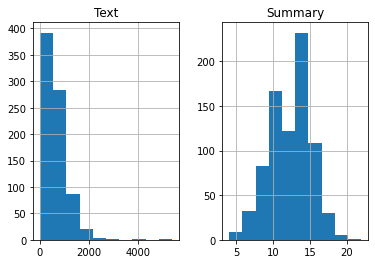

In [10]:
text_count = []
summary_count = []
for sent in df['cleaned_news_text']:
  text_count.append(len(sent.split()))
for sent in df['cleaned_headline']:
  summary_count.append(len(sent.split()))
graph = pd.DataFrame()
graph['Text'] = text_count
graph['Summary'] = summary_count
graph.hist(bins=10)
plt.show()

In [11]:
cnt = 0
for sent in df['cleaned_news_text']:
  if len(sent.split())<=1500:
    cnt=cnt+1
print(cnt/len(df['cleaned_news_text']))

0.9544303797468354


In [12]:
max_text_len = 1500
max_summary_len = 20

In [13]:
cleaned_text = np.array(df['cleaned_news_text'])
cleaned_summary= np.array(df['cleaned_headline'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head(2)

,text,summary
0,a young boy in tucuman argentina suffered an u...,_START_ boy swallows piece of pet toy and can ...
1,stephen paddock brought an arsenal of weapons ...,_START_ las vegas gunman had cache of weapons ...


In [14]:
post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,a young boy in tucuman argentina suffered an u...,sostok _START_ boy swallows piece of pet toy a...
1,stephen paddock brought an arsenal of weapons ...,sostok _START_ las vegas gunman had cache of w...


In [15]:
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [16]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  72.81258018401086


In [17]:
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 7418


In [18]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 91.18705035971223
Size of vocabulary in Y = 246


In [19]:
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [20]:
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [21]:
def get_compiled_model() :
  latent_dim = 300
  embedding_dim = 200

  # Encoder
  encoder_inputs = Input(shape=(max_text_len, ))

  # Embedding layer
  enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

  # Encoder LSTM 1
  encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
  (encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

  # Encoder LSTM 2
  encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
  (encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

  # Encoder LSTM 3
  encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
  (encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

  # Set up the decoder, using encoder_states as the initial state
  decoder_inputs = Input(shape=(None, ))

  # Embedding layer
  dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  #  Decoder LSTM
  decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
  (decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

  # Dense layer
  decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)

# Define the model

  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
  return model

with strategy.scope():
  model = get_compiled_model()
  

model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)        

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [25]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=10,
    callbacks=[es],
    batch_size=50,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]),
    )

Epoch 1/10


ResourceExhaustedError: ignored